In [116]:
## Trim down imports to only neccesary 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from transformers import AutoFeatureExtractor, ViTForImageClassification, ViTModel
from PIL import Image
import requests
import torch
from torchvision.transforms import v2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)

from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.utils.data import Subset
from collections import namedtuple

import datasets_1 as datasets
from sklearn.preprocessing import StandardScaler

import os
import datetime

In [2]:
svid_t = datasets.load_SVID_temperature()
svid_o = datasets.load_SVID_other(keep_all=True)
svid_b = datasets.load_SVID_brGDGTs()


DATA_DIR = "../data/"
with open(os.path.join(DATA_DIR, "SVID_brGDGTs.csv"), "r") as inf:
        df = pd.read_csv(inf)
        
df.head()

svid_o.head()

,Lake,Sediment_Depth,MBT,fIa
0,SVID,0,0.126995,0.113324
1,SVID,7,0.133994,0.120358
2,SVID,15,0.137242,0.122855
3,SVID,23,0.132345,0.117512
4,SVID,31,0.144388,0.129024


,Sediment_Depth,Age,%TOC,d13C,d15N,%TN,C/N,BSi,year
0,0.0,11.6732,3.6,-25.9,0.7,0.4,8.0,76.672,2020.0000
1,3.0,52.5294,3.1,-25.8,0.7,0.4,8.5,59.449,1979.1438
2,7.0,99.2222,2.9,-25.7,0.6,0.3,9.4,64.895,1932.4510
3,11.0,145.9150,3.1,-25.9,0.3,0.3,9.4,54.073,1885.7582
4,15.0,192.6078,3.1,-25.9,0.7,0.3,9.3,57.037,1839.0654


In [29]:
class ImageData:
    def __init__(self, name, image):
        self.name = name
        self.image = image
        self.start = None
        self.end = None

ILLUME-SVID20-1B-7B-1-A.jpg 1B-7B-1-A


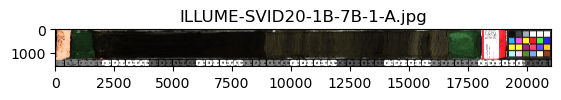

ILLUME-SVID20-1B-6B-1-A.jpg 1B-6B-1-A


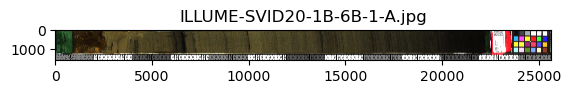

ILLUME-SVID20-1B-2B-1-A_complete.jpg 1B-2B-1-A


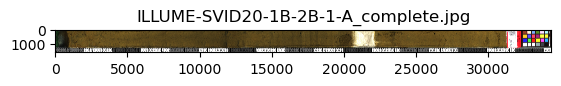

ILLUME-SVID20-1B-3B-1-A_complete.jpg 1B-3B-1-A


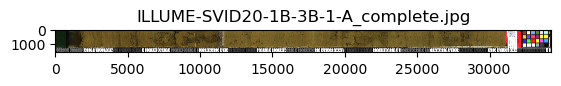

ILLUME-SVID20-1B-5B-1-A_complete.jpg 1B-5B-1-A


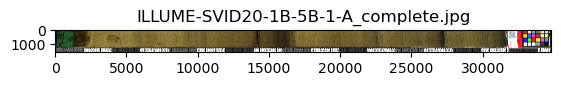

ILLUME-SVID20-1B-4B-1-A_complete.jpg 1B-4B-1-A


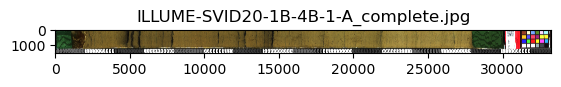

ILLUME-SVID20-1B-1B-1-A_complete.jpg 1B-1B-1-A


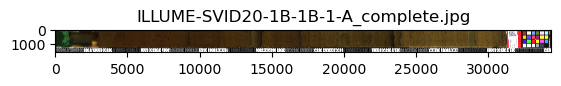

In [21]:
full_SVID = []
cropped_SVID = []

def sortimg(img):
    return img.name

def load_and_display_images(folder_path, img_store):
    # List all files in the folder
    files = os.listdir(folder_path)

    for file in files:
        # Construct full file path
        file_path = os.path.join(folder_path, file)
        obj_name = file[14:23]
        print(file,obj_name)
        # Check if the file is an image (you can add more extensions if needed)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Open the image
            img = Image.open(file_path)

            new_img = ImageData(name = obj_name, image = img)
            
            # Display the image
            plt.imshow(img)
            plt.title(file)
            plt.show()
            
            img_store.append(new_img)

# Replace 'your_folder_path' with the path to the folder containing your images

load_and_display_images('img_data/SVID',full_SVID)
## reverse = False because 1B-7B seems darkest so would make sense for it to be on the bottom
full_SVID.sort(key=sortimg,reverse=False)

[<__main__.ImageData object at 0x297d33450>, <__main__.ImageData object at 0x293c98e50>, <__main__.ImageData object at 0x293cd1550>, <__main__.ImageData object at 0x293002650>, <__main__.ImageData object at 0x293c27390>, <__main__.ImageData object at 0x292fdb7d0>, <__main__.ImageData object at 0x2937092d0>]


<Figure size 1000x500 with 0 Axes>

<Axes: >

(-0.5, 34368.5, 1565.5, -0.5)

Text(0.5, 1.0, 'Image 1B-1B-1-A')

"# Display the second image\nplt.subplot(1, 2, 2)  # (rows, columns, panel number)\nplt.imshow(image2)\nplt.axis('off')  # Hide the axis\nplt.title('1B-4B')"

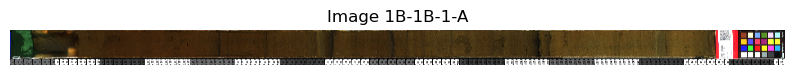

In [5]:
print(full_SVID)
# Set up the figure and subplots
plt.figure(figsize=(10, 5))  # The figure size can be adjusted as needed

image = full_SVID[0]
# Display the first image
plt.subplot(1, 1, 1)  # (rows, columns, panel number)
plt.imshow(image.image)
plt.axis('off')  # Hide the axis
plt.title(f'Image {image.name}')

'''# Display the second image
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.imshow(image2)
plt.axis('off')  # Hide the axis
plt.title('1B-4B')'''

# Show the plot
plt.show()

In [ ]:
##### CROPPING IMAGES --- IDK HOW TO DO THIS NOT MANUALLY

(-0.5, 30274.5, 1299.5, -0.5)

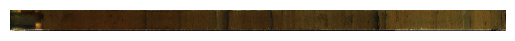

In [28]:
## Cropping Unnecesary parts
# Left, top, right, bottom

## This is only guessing, do something better potentially. More fine grain
## 1. 1000 0 31275 1300
    ## 6-157 cm
box = (1000, 0, 31275, 1300)

# Crop the image
cropped_image = full_SVID[0].image.crop(box)
full_SVID[0].start = 1000
full_SVID[0].end = 31275

# Display the cropped image
plt.imshow(cropped_image)
plt.axis('off')  # This hides the axis
plt.show()

cropped_SVID.append(ImageData(full_SVID[0].name,cropped_image))

(-0.5, 30489.5, 1299.5, -0.5)

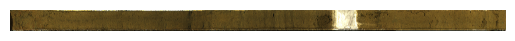

In [27]:
## Cropping Unnecesary parts
# Left, top, right, bottom

## This is only guessing, do something better potentially. More fine grain
## 2. 800 0 31290 1300
    ## 5-157 cm
box = (800, 0, 31290, 1300)
full_SVID[1].start = 800
full_SVID[1].end = 31290

# Crop the image
cropped_image = full_SVID[1].image.crop(box)

# Display the cropped image
plt.imshow(cropped_image)
plt.axis('off')  # This hides the axis
plt.show()


cropped_SVID.append(ImageData(full_SVID[1].name,cropped_image))




(-0.5, 30299.5, 1299.5, -0.5)

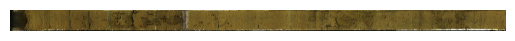

In [26]:
## Cropping Unnecesary parts
# Left, top, right, bottom

## This is only guessing, do something better potentially. More fine grain
## 3. 800 0 31100 1300
    ## 5-156 cm
box = (800, 0, 31100, 1300)

# Crop the image
cropped_image = full_SVID[2].image.crop(box)
full_SVID[2].start = 800
full_SVID[2].end = 31100

# Display the cropped image
plt.imshow(cropped_image)
plt.axis('off')  # This hides the axis
plt.show()

cropped_SVID.append(ImageData(full_SVID[2].name,cropped_image))



(-0.5, 26799.5, 1299.5, -0.5)

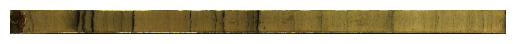

In [25]:
## Cropping Unnecesary parts
# Left, top, right, bottom

## This is only guessing, do something better potentially. More fine grain
## 4. 1200 0 28000 1300
    ## 7-140.5 cm
box = (1200, 0, 28000, 1300)

# Crop the image
cropped_image = full_SVID[3].image.crop(box)
full_SVID[3].start = 1200
full_SVID[3].end = 28000

# Display the cropped image
plt.imshow(cropped_image)
plt.axis('off')  # This hides the axis
plt.show()


cropped_SVID.append(ImageData(full_SVID[3].name,cropped_image))




(-0.5, 30499.5, 1299.5, -0.5)

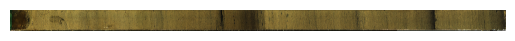

In [24]:
## Cropping Unnecesary parts
# Left, top, right, bottom

## This is only guessing, do something better potentially. More fine grain
## 5. 1200 0 31700 1300
    ## 7-159 cm
box = (1200, 0, 31700, 1300)

# Crop the image
cropped_image = full_SVID[4].image.crop(box)
full_SVID[4].start = 1200
full_SVID[4].end = 31700

# Display the cropped image
plt.imshow(cropped_image)
plt.axis('off')  # This hides the axis
plt.show()


cropped_SVID.append(ImageData(full_SVID[4].name,cropped_image))



(-0.5, 21449.5, 1299.5, -0.5)

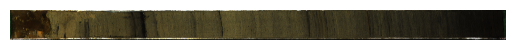

In [23]:
## Cropping Unnecesary parts
# Left, top, right, bottom

## This is only guessing, do something better potentially. More fine grain
## 6. 875 0 22325 1300
    ## 5.5-112 cm
box = (875, 0, 22325, 1300)

# Crop the image
cropped_image = full_SVID[5].image.crop(box)
full_SVID[5].start = 875
full_SVID[5].end = 22325

# Display the cropped image
plt.imshow(cropped_image)
plt.axis('off')  # This hides the axis
plt.show()





(-0.5, 15149.5, 1299.5, -0.5)

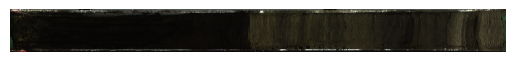

In [41]:
## Cropping Unnecesary parts
# Left, top, right, bottom

## This is only guessing, do something better potentially. More fine grain
## 7. 1600 0 16750 1300
    ## 9-84 cm
box = (1600, 0, 16750, 1300)

# Crop the image
cropped_image = full_SVID[6].image.crop(box)
full_SVID[6].start = 1600
full_SVID[6].end = 16750

# Display the cropped image
plt.imshow(cropped_image)
plt.axis('off')  # This hides the axis
plt.show()








In [109]:
## 997 is good chunk size

## Images loaded, tabular loaded, Link together

## 1. 1000 0 31275 1300
## 2. 800 0 31290 1300
## 3. 800 0 31100 1300
## 4. 1200 0 28000 1300
## 5. 1200 0 31700 1300
## 6. 875 0 22325 1300
## 7. 1000 0 16750 1300

bounding = [(1000, 0, 31275, 1300),(800, 0, 31290, 1300),(800, 0, 31100, 1300),
            (1200, 0, 28000, 1300),(1200, 0, 31700, 1300),(875, 0, 22325, 1300),
           (1000, 0, 16750, 1300)]



full_depth = 0
chunk_size = 997
chunks = []
chunk_labels = []

## Pixels to cm
    ## To make sure our depths are accurate
p_to_cm = 5/997

target = 'BSi'

j = 0
for i,object in enumerate(full_SVID):
    full_end = object.end
    start_pixel = object.start
    end_pixel = object.start + chunk_size
    while end_pixel <= full_end:
        box = (start_pixel, 0, end_pixel, 1300)
        chunk = object.image.crop(box)
        
        chunks.append(chunk) 
        
        ## Looks good, dont need to display for now
        # Display the chunk
        #plt.figure()  # Create a new figure for each chunk
        #plt.imshow(chunk)
        #plt.axis('off')  # Hide the axis
        #plt.title(f'Chunk {j+1}')
        #plt.show()
        
        
        ## Adding on labels
        section_data = svid_o[(svid_o['Sediment_Depth'] >= full_depth) & 
                        (svid_o['Sediment_Depth'] < (full_depth+5))]
    
        # Calculate the average target value for the segment
        average_target = section_data[target].mean()
        #print(f"target for section {full_depth} to {full_depth + 5}: {average_target}\n")
        chunk_labels.append(average_target)
        
        
        ## While loop Increments
        start_pixel += chunk_size
        end_pixel += chunk_size
        j += 1
        if end_pixel > full_end:
            full_depth += (full_end - (end_pixel - chunk_size)) * p_to_cm
        else:
            full_depth += 5
            
    #print(f"\n end of image {i}\n")
        
        
        
    





In [63]:
# Convert your lists to numpy arrays
images_array = np.array(chunks)
labels_array = np.array(chunk_labels)

# Assuming NaN is represented as np.nan in labels_array
# Create boolean masks
nan_mask = np.isnan(labels_array)
non_nan_mask = ~nan_mask

# Filter the arrays
images_test = images_array[nan_mask]
images_known = images_array[non_nan_mask]
labels_test = labels_array[nan_mask]
labels_known = labels_array[non_nan_mask]






In [64]:
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-tiny-patch16-224')
inputs = feature_extractor(images=images_known, return_tensors="pt")

print(inputs['pixel_values'][0].shape)

/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


torch.Size([3, 224, 224])


In [110]:
class CustomDataset(Dataset):
    def __init__(self, pixel_values, labels):
        self.pixel_values = pixel_values
        self.labels = labels

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        image = self.pixel_values[idx]
        label = self.labels[idx]
        return image, label

# Assuming your pixel_values are already a tensor in the shape [num_images, channels, height, width]
# and labels is a list or a 1-D tensor of label values:
pixel_values_tensor = inputs['pixel_values'] 
labels_tensor = torch.tensor(labels_known, dtype=torch.float32)

# Create the custom dataset
dataset = CustomDataset(pixel_values_tensor, labels_tensor)

# Split the dataset into training and validation sets
train_indices, val_indices = train_test_split(range(len(labels_tensor)), test_size=0.2, random_state=42)

# Subset for train and validation=
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create a dataloader for both the training and validation sets
    ## 5 seems like a fine batch size
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

In [66]:
## Pretrained model

class CustomViTEmbeddingModel(torch.nn.Module):
    def __init__(self, original_model):
        super(CustomViTEmbeddingModel, self).__init__()
        
        # Extract the necessary layers from the original model
        self.embeddings = original_model.vit.embeddings  #.patch_embeddings
        self.encoder_layer_0 = original_model.vit.encoder.layer[0]
        self.encoder_layer_1 = original_model.vit.encoder.layer[1]
        
        # Assume a square grid of patches to reshape the sequence of patches back into a 2D grid
            ## image: 224x224 ; patch size: 16x16 --> 14x14 
        self.num_patches_side = 14

    def forward(self, x):
        # Apply the embeddings layer
        x = self.embeddings(x)
        
        # Pass the result through the first and second encoder layers
        x = self.encoder_layer_0(x)[0]  # [0] to get the hidden states
        x = self.encoder_layer_1(x)[0]  # [0] to get the hidden states
        
        # x is now the sequence of embeddings for the patches
            # The output x will be a sequence of embeddings, one for each patch of the input images.
            # If you're looking for a single vector representation per image, typically the class token embedding (the first token) is used. 
            # If the model doesn't use a class token, you might need to apply a different pooling strategy over the patch embeddings.
        
        ## Updating to reshape
        
        # Before reshaping, x is in shape [batch_size, num_patches+1, embedding_dim]
        # We discard the first token which is used for classification in the original ViT model
        x = x[:, 1:, :]  # Now in shape [batch_size, num_patches, embedding_dim]
        
        # Reshape to [batch_size, num_patches_side, num_patches_side, embedding_dim]
        x = x.reshape(-1, self.num_patches_side, self.num_patches_side, x.size(-1))

        # Permute to get [batch_size, embedding_dim, num_patches_side, num_patches_side]
        # This is a pseudo-spatial 2D grid, where embedding_dim becomes the channel dimension
        x = x.permute(0, 3, 1, 2)
        
        return x

# Load the pre-trained ViT model
pretrained_vit = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')

## Freeze params
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Create model w first three layers and create embedding
custom_model = CustomViTEmbeddingModel(pretrained_vit)
embeddings = custom_model(inputs['pixel_values']) 

print(embeddings[0].shape)


torch.Size([192, 14, 14])


In [113]:
## Adding in CNN component


## CNN for regression
class RegressionCNN(nn.Module):
    def __init__(self, embedding_dim):
        super(RegressionCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=embedding_dim, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        
        # Implementing dropout
        self.dropout = nn.Dropout(p=0.5)

        # Adaptive pooling layer to pool down to 1x1
        self.adapt_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final fully connected layer for regression
        self.fc = nn.Linear(in_features=128, out_features=1)

    def forward(self, x):
        # Apply first convolution, batch norm, and activation
        x = self.relu1(self.bn1(self.conv1(x)))
        
        # Apply second convolution, batch norm, and activation
        x = self.relu2(self.bn2(self.conv2(x)))

        # Apply dropout
        x = self.dropout(x)

        # Pool the output from the convolutional layers
        x = self.adapt_pool(x)

        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layer for regression
        x = self.fc(x)
        return x

def calculate_rmse_and_r2(loader, model):
    model.eval()
    targets, predictions = [], []
    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            embeddings = custom_model(images)  # Get embeddings from the ViT
            preds = cnn_model(embeddings)  # Pass embeddings to the CNN
            predictions.extend(preds.view(-1).tolist())
            targets.extend(labels.tolist())
            
    predictions = torch.tensor(predictions)
    targets = torch.tensor(targets)
    rmse_value = torch.sqrt(nn.functional.mse_loss(predictions, targets))
    r2_value = r2_score(targets, predictions)
    return rmse_value.item(), r2_value

RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 1/50
Train Loss: 3.4150, Train RMSE: 1.0459, Train R2: -0.9753
Val RMSE: 0.9607, Val R2: -1.0919


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 2/50
Train Loss: 0.5865, Train RMSE: 0.3601, Train R2: 0.7658
Val RMSE: 0.4674, Val R2: 0.5048


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 3/50
Train Loss: 0.1650, Train RMSE: 0.2630, Train R2: 0.8751
Val RMSE: 0.3776, Val R2: 0.6768


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 4/50
Train Loss: 0.1921, Train RMSE: 0.2380, Train R2: 0.8977
Val RMSE: 0.4107, Val R2: 0.6176


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 5/50
Train Loss: 0.1826, Train RMSE: 0.2663, Train R2: 0.8720
Val RMSE: 0.3510, Val R2: 0.7208


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 6/50
Train Loss: 0.1399, Train RMSE: 0.1992, Train R2: 0.9284
Val RMSE: 0.3636, Val R2: 0.7004


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 7/50
Train Loss: 0.1288, Train RMSE: 0.2345, Train R2: 0.9007
Val RMSE: 0.4364, Val R2: 0.5683


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 8/50
Train Loss: 0.1139, Train RMSE: 0.2116, Train R2: 0.9191
Val RMSE: 0.3292, Val R2: 0.7543


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 9/50
Train Loss: 0.1153, Train RMSE: 0.1301, Train R2: 0.9694
Val RMSE: 0.3537, Val R2: 0.7165


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 10/50
Train Loss: 0.1237, Train RMSE: 0.3981, Train R2: 0.7139
Val RMSE: 0.6084, Val R2: 0.1611


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 11/50
Train Loss: 0.1160, Train RMSE: 0.1828, Train R2: 0.9397
Val RMSE: 0.3284, Val R2: 0.7555


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 12/50
Train Loss: 0.1233, Train RMSE: 0.1377, Train R2: 0.9657
Val RMSE: 0.3492, Val R2: 0.7237


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 13/50
Train Loss: 0.0915, Train RMSE: 0.1339, Train R2: 0.9676
Val RMSE: 0.3740, Val R2: 0.6830


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 14/50
Train Loss: 0.0860, Train RMSE: 0.1810, Train R2: 0.9408
Val RMSE: 0.3442, Val R2: 0.7314


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 15/50
Train Loss: 0.0643, Train RMSE: 0.0946, Train R2: 0.9839
Val RMSE: 0.3441, Val R2: 0.7317


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 16/50
Train Loss: 0.1375, Train RMSE: 0.1043, Train R2: 0.9803
Val RMSE: 0.3702, Val R2: 0.6894


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 17/50
Train Loss: 0.0665, Train RMSE: 0.1373, Train R2: 0.9660
Val RMSE: 0.3597, Val R2: 0.7068


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 18/50
Train Loss: 0.0738, Train RMSE: 0.1271, Train R2: 0.9709
Val RMSE: 0.3476, Val R2: 0.7261


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 19/50
Train Loss: 0.0810, Train RMSE: 0.1609, Train R2: 0.9532
Val RMSE: 0.3160, Val R2: 0.7737


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 20/50
Train Loss: 0.1008, Train RMSE: 0.1211, Train R2: 0.9735
Val RMSE: 0.3967, Val R2: 0.6432


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 21/50
Train Loss: 0.0662, Train RMSE: 0.1106, Train R2: 0.9779
Val RMSE: 0.3157, Val R2: 0.7741


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 22/50
Train Loss: 0.0515, Train RMSE: 0.0867, Train R2: 0.9864
Val RMSE: 0.3743, Val R2: 0.6824


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 23/50
Train Loss: 0.0302, Train RMSE: 0.0867, Train R2: 0.9864
Val RMSE: 0.3607, Val R2: 0.7051


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 24/50
Train Loss: 0.0510, Train RMSE: 0.1139, Train R2: 0.9766
Val RMSE: 0.3450, Val R2: 0.7303


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 25/50
Train Loss: 0.0521, Train RMSE: 0.1369, Train R2: 0.9662
Val RMSE: 0.3714, Val R2: 0.6873


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 26/50
Train Loss: 0.0744, Train RMSE: 0.2303, Train R2: 0.9042
Val RMSE: 0.4929, Val R2: 0.4493


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 27/50
Train Loss: 0.0535, Train RMSE: 0.3590, Train R2: 0.7672
Val RMSE: 0.4211, Val R2: 0.5981


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 28/50
Train Loss: 0.1021, Train RMSE: 0.1527, Train R2: 0.9579
Val RMSE: 0.4159, Val R2: 0.6080


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 29/50
Train Loss: 0.0619, Train RMSE: 0.2712, Train R2: 0.8672
Val RMSE: 0.3977, Val R2: 0.6416


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 30/50
Train Loss: 0.0793, Train RMSE: 0.2373, Train R2: 0.8983
Val RMSE: 0.4068, Val R2: 0.6249


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 31/50
Train Loss: 0.0480, Train RMSE: 0.1331, Train R2: 0.9680
Val RMSE: 0.3411, Val R2: 0.7363


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 32/50
Train Loss: 0.0632, Train RMSE: 0.2622, Train R2: 0.8759
Val RMSE: 0.5588, Val R2: 0.2923


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 33/50
Train Loss: 0.0645, Train RMSE: 0.2386, Train R2: 0.8972
Val RMSE: 0.4011, Val R2: 0.6354


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 34/50
Train Loss: 0.0916, Train RMSE: 0.1608, Train R2: 0.9533
Val RMSE: 0.4541, Val R2: 0.5327


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 35/50
Train Loss: 0.0408, Train RMSE: 0.1503, Train R2: 0.9592
Val RMSE: 0.3932, Val R2: 0.6496


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 36/50
Train Loss: 0.0766, Train RMSE: 0.2222, Train R2: 0.9109
Val RMSE: 0.4738, Val R2: 0.4913


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 37/50
Train Loss: 0.0580, Train RMSE: 0.0758, Train R2: 0.9896
Val RMSE: 0.3565, Val R2: 0.7119


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 38/50
Train Loss: 0.0466, Train RMSE: 0.0805, Train R2: 0.9883
Val RMSE: 0.3896, Val R2: 0.6560


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 39/50
Train Loss: 0.0486, Train RMSE: 0.1329, Train R2: 0.9681
Val RMSE: 0.3555, Val R2: 0.7136


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 40/50
Train Loss: 0.0828, Train RMSE: 0.2394, Train R2: 0.8965
Val RMSE: 0.3826, Val R2: 0.6681


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 41/50
Train Loss: 0.0385, Train RMSE: 0.0864, Train R2: 0.9865
Val RMSE: 0.3974, Val R2: 0.6420


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 42/50
Train Loss: 0.0760, Train RMSE: 0.2243, Train R2: 0.9091
Val RMSE: 0.5045, Val R2: 0.4232


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 43/50
Train Loss: 0.0464, Train RMSE: 0.0963, Train R2: 0.9832
Val RMSE: 0.3578, Val R2: 0.7098


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 44/50
Train Loss: 0.1084, Train RMSE: 0.1472, Train R2: 0.9609
Val RMSE: 0.4271, Val R2: 0.5866


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 45/50
Train Loss: 0.0763, Train RMSE: 0.1670, Train R2: 0.9496
Val RMSE: 0.3507, Val R2: 0.7212


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 46/50
Train Loss: 0.0319, Train RMSE: 0.1263, Train R2: 0.9712
Val RMSE: 0.3617, Val R2: 0.7035


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 47/50
Train Loss: 0.0496, Train RMSE: 0.1865, Train R2: 0.9372
Val RMSE: 0.4680, Val R2: 0.5036


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 48/50
Train Loss: 0.0483, Train RMSE: 0.1725, Train R2: 0.9462
Val RMSE: 0.4489, Val R2: 0.5432


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 49/50
Train Loss: 0.0391, Train RMSE: 0.1211, Train R2: 0.9735
Val RMSE: 0.3604, Val R2: 0.7056


RegressionCNN(
  (conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 50/50
Train Loss: 0.0534, Train RMSE: 0.2706, Train R2: 0.8678
Val RMSE: 0.3959, Val R2: 0.6448


<Figure size 1000x500 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training Loss Over Epochs')

<Axes: >

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'RMSE')

Text(0.5, 1.0, 'RMSE Over Epochs')

Text(0.5, 0.98, 'BSi RMSE Over Epochs: 0.001 LR, BN ')

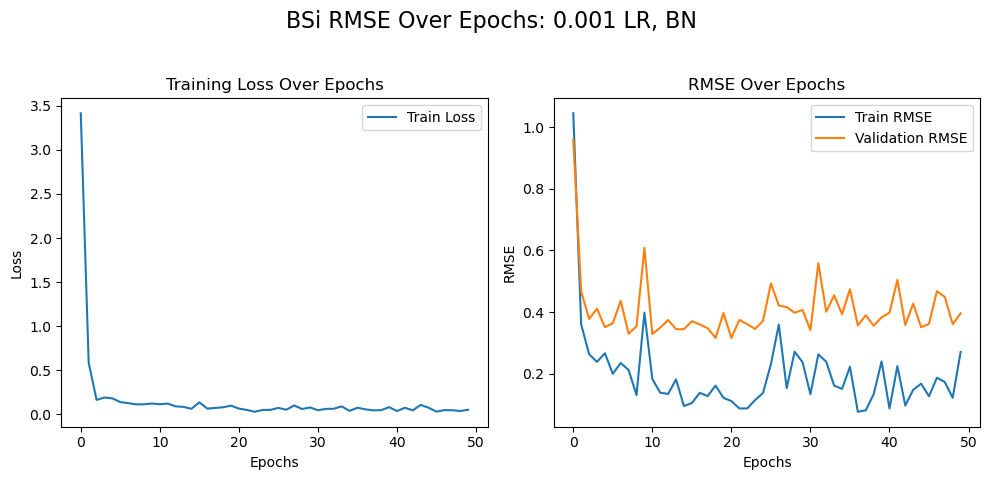

In [115]:
# Training loop
num_epochs = 50


# Training loop
train_losses = []
train_rmses = []
val_rmses = []

# Instantiate the last model
cnn_model = RegressionCNN(embedding_dim=192)

# Define a Loss Function and Optimizer
loss_function = nn.MSELoss()

## Started w 0.001, went up to 0.01
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    cnn_model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        images, labels = batch
        embeddings = custom_model(images)  # Get embeddings from the ViT
        predictions = cnn_model(embeddings)  # Pass embeddings to the CNN
        loss = loss_function(predictions.squeeze(), labels) 
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Calculate average loss over the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Calculate RMSE and R-squared for training and validation sets
    train_rmse, train_r2 = calculate_rmse_and_r2(train_loader, cnn_model)
    val_rmse, val_r2 = calculate_rmse_and_r2(val_loader, cnn_model)
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)
    
    # Print out the metrics
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {avg_train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Train R2: {train_r2:.4f}')
    print(f'Val RMSE: {val_rmse:.4f}, Val R2: {val_r2:.4f}')

# Plotting
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(train_rmses, label='Train RMSE')
plt.plot(val_rmses, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.legend()

# Add an overall title to the plot
plt.suptitle(f'{target} RMSE Over Epochs: 0.001 LR, BN ', fontsize=16)

# Adjust layout to make room for the overall title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### 0.0001 seems best

timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
save_dir = 'test_results/SVID'

# Saving the plot
# Ensure the target directory exists
os.makedirs(save_dir, exist_ok=True)
filename = f'{target}_rmse_plot_{timestamp}.png'

if target == "C/N":
   filename = f'CN_rmse_plot_{timestamp}.png' 

plt.savefig(os.path.join(save_dir, filename))

plt.show()

